# Sparkify Churn Prediction

## 1. Load and clean dataset
Loading and cleaning the dataset, checking for invalid or missing data - for example, records without user IDs or session IDs.

In [56]:
# Import libraries

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, from_unixtime, substring, instr, encode, decode, split, month, desc, sum as Fsum
from pyspark.sql.types import LongType, IntegerType, StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import ticker

from build_axes import Hist, Barh, BarhStacked2
plt.style.use('ggplot')  # Remove this line after all the visualizations are custom made

from user_agents import parse

In [ ]:
# Configure pandas output display settings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
# Correct autocomplete not working

%config Completer.use_jedi = False

In [3]:
# Create spark session

spark = SparkSession \
    .builder \
    .appName('Sparkify') \
    .getOrCreate()

In [4]:
# Show link to spark UI at localhost:4040

spark

In [5]:
# Read sparkify dataset

filepath = 'mini_sparkify_event_data.json'
users_log = spark.read.json(filepath)

# Full dataset (12 Gb, 20 million rows)
# event_data = 's3n://udacity-dsnd/sparkify/sparkify_event_data.json'

# Mini dataset (128 Mb, 200 thousand rows, 1% of the full dataset)
# event_data = 's3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json'

In [6]:
print('users_log shape:', (users_log.count(), len(users_log.columns)))

users_log shape: (286500, 18)


In [7]:
users_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Adjust the data types

users_log = users_log.withColumn('registration', from_unixtime(col('registration') / 1000))
users_log = users_log.withColumn('ts', from_unixtime(col('ts') / 1000))
users_log = users_log.withColumn('userId', col('userId').cast(LongType()))

In [9]:
# Show example of string with wrong encoding

record = '''userId == 30
            and sessionId == 29
            and itemInSession == 68'''

encoding_example = users_log.where(record).collect()[0][0]

print('String should be:\t Björk')
print('String currently is:\t {}'.format(encoding_example))

String should be:	 Björk
String currently is:	 BjÃÂ¶rk


In [10]:
def encode_decode_column(df, column, encoding, decoding):
    """Encode a column from a dataframe and then decode it.
    
    Parameters:
        df (Spark dataframe): The dataframe that contains the column.
        column (String): The name of the column, from the df, to perform the encode and decode.
        encoding (string): The charset of the encoding (one of 'US-ASCII', 'ISO-8859-1', 'UTF-8', 'UTF-16BE', 'UTF-16LE', 'UTF-16').
        decoding (string): The charset of the decoding (one of 'US-ASCII', 'ISO-8859-1', 'UTF-8', 'UTF-16BE', 'UTF-16LE', 'UTF-16').
    
    Returns:
        df (Spark dataframe):
        
    Example:
        df = encode_decode_column(df, 'column_name', 'ISO-8859-1', 'UTF-8')
    """
    
    df = df.withColumn(column, encode(column, encoding))
    df = df.withColumn(column, decode(column, decoding))
    
    return df

In [11]:
date_columns = ['registration', 'ts']
categorical_columns = list(filter(lambda c: c[1] == 'string', users_log.dtypes))
categorical_columns = [c[0] for c in categorical_columns if c[0] not in date_columns]

In [12]:
# Fix the wrong encoding for the columns that are strings,
# and in order to retrieve the correct characters the encode-decode process must be done twice.

for column in categorical_columns:
    users_log = encode_decode_column(users_log, column, 'ISO-8859-1', 'UTF-8')
    users_log = encode_decode_column(users_log, column, 'ISO-8859-1', 'UTF-8')

In [13]:
# Test if the previous example is correct now

encoding_example_fixed = users_log.where(record).collect()[0][0]

print('String should be:\t Björk')
print('String currently is:\t {}'.format(encoding_example_fixed))

String should be:	 Björk
String currently is:	 Björk


In [14]:
users_log.limit(5).toPandas().head()

artist       auth firstName gender  itemInSession lastName  \
0    Martha Tilston  Logged In     Colin      M             50  Freeman   
1  Five Iron Frenzy  Logged In     Micah      M             79     Long   
2      Adam Lambert  Logged In     Colin      M             51  Freeman   
3            Enigma  Logged In     Micah      M             80     Long   
4         Daft Punk  Logged In     Colin      M             52  Freeman   

      length level                        location method      page  \
0  277.89016  paid                 Bakersfield, CA    PUT  NextSong   
1  236.09424  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong   
2  282.82730  paid                 Bakersfield, CA    PUT  NextSong   
3  262.71302  free  Boston-Cambridge-Newton, MA-NH    PUT  NextSong   
4  223.60771  paid                 Bakersfield, CA    PUT  NextSong   

          registration  sessionId                           song  status  \
0  2018-09-28 19:22:42         29                      Rockpools     200   
1  2018-09-30 15:20:30          8                         Canada     200   
2  2018-09-28 19:22:42         29              Time For Miracles     200   
3  2018-09-30 15:20:30          8    Knocking On Forbidden Doors     200   
4  2018-09-28 19:22:42         29  Harder Better Faster Stronger     200   

                    ts  \
0  2018-09-30 21:01:57   
1  2018-09-30 21:03:00   
2  2018-09-30 21:06:34   
3  2018-09-30 21:06:56   
4  2018-09-30 21:11:16   

                                                                                                         userAgent  \
0                                         Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0   
1  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"   
2                                         Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0   
3  "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"   
4                                         Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0   

   userId  
0      30  
1       9  
2      30  
3       9  
4      30

In [15]:
numerical_columns = list(filter(lambda c: c[1] == 'bigint' or c[1] == 'double', users_log.dtypes))
numerical_columns = list(item[0] for item in numerical_columns)

In [16]:
summary = users_log.select(numerical_columns).describe().toPandas().set_index('summary')
summary.index.name = None
summary

itemInSession              length          sessionId  \
count               286500              228108             286500   
mean    114.41421291448516  249.11718197783722  1041.526554973822   
stddev  129.76726201141085   99.23517921058324  726.7762634630834   
min                      0             0.78322                  1   
max                   1321          3024.66567               2474   

                    status              userId  
count               286500              278154  
mean    210.05459685863875   59682.02278593872  
stddev   31.50507848842202  109091.94999910519  
min                    200                   2  
max                    404              300025

In [17]:
# ADD BACK THE FUNCTION TO SHOW THE PERIOD OF THE DATE FIELDS

# Earliest registration: 2018-03-18 10:44:35
# Latest registration: 2018-11-26 13:49:14
# Earliest ts: 2018-09-30 21:01:57
# Latest ts: 2018-12-02 23:11:16

In [18]:
users_log_valid = users_log.dropna(how='any', subset=['userId', 'sessionId'])

old_rows, old_columns = users_log.count(), users_log.columns
new_rows, new_columns = users_log_valid.count(), users_log_valid.columns

print('users_log shape:\t', (old_rows, len(old_columns)))
print('users_log_valid shape:\t', (new_rows, len(new_columns)))
print('{} rows with empty user and session IDs removed'.format(old_rows - new_rows))

users_log shape:	 (286500, 18)
users_log_valid shape:	 (278154, 18)
8346 rows with empty user and session IDs removed


In [19]:
distinct_user_ids = users_log_valid.dropDuplicates(['userId']).count()
print('Distinct user IDs:', distinct_user_ids)

Distinct user IDs: 225


## 2. Exploratory Data Analysis

### 2.1. Visualizing the entire log

#### 2.1.1. Numerical features

In [20]:
n1 = users_log_valid.select('userId').toPandas()
n2 = users_log_valid.select('sessionId').toPandas()
n3 = users_log_valid.select('itemInSession').toPandas()
n4 = users_log_valid.select('length').toPandas()

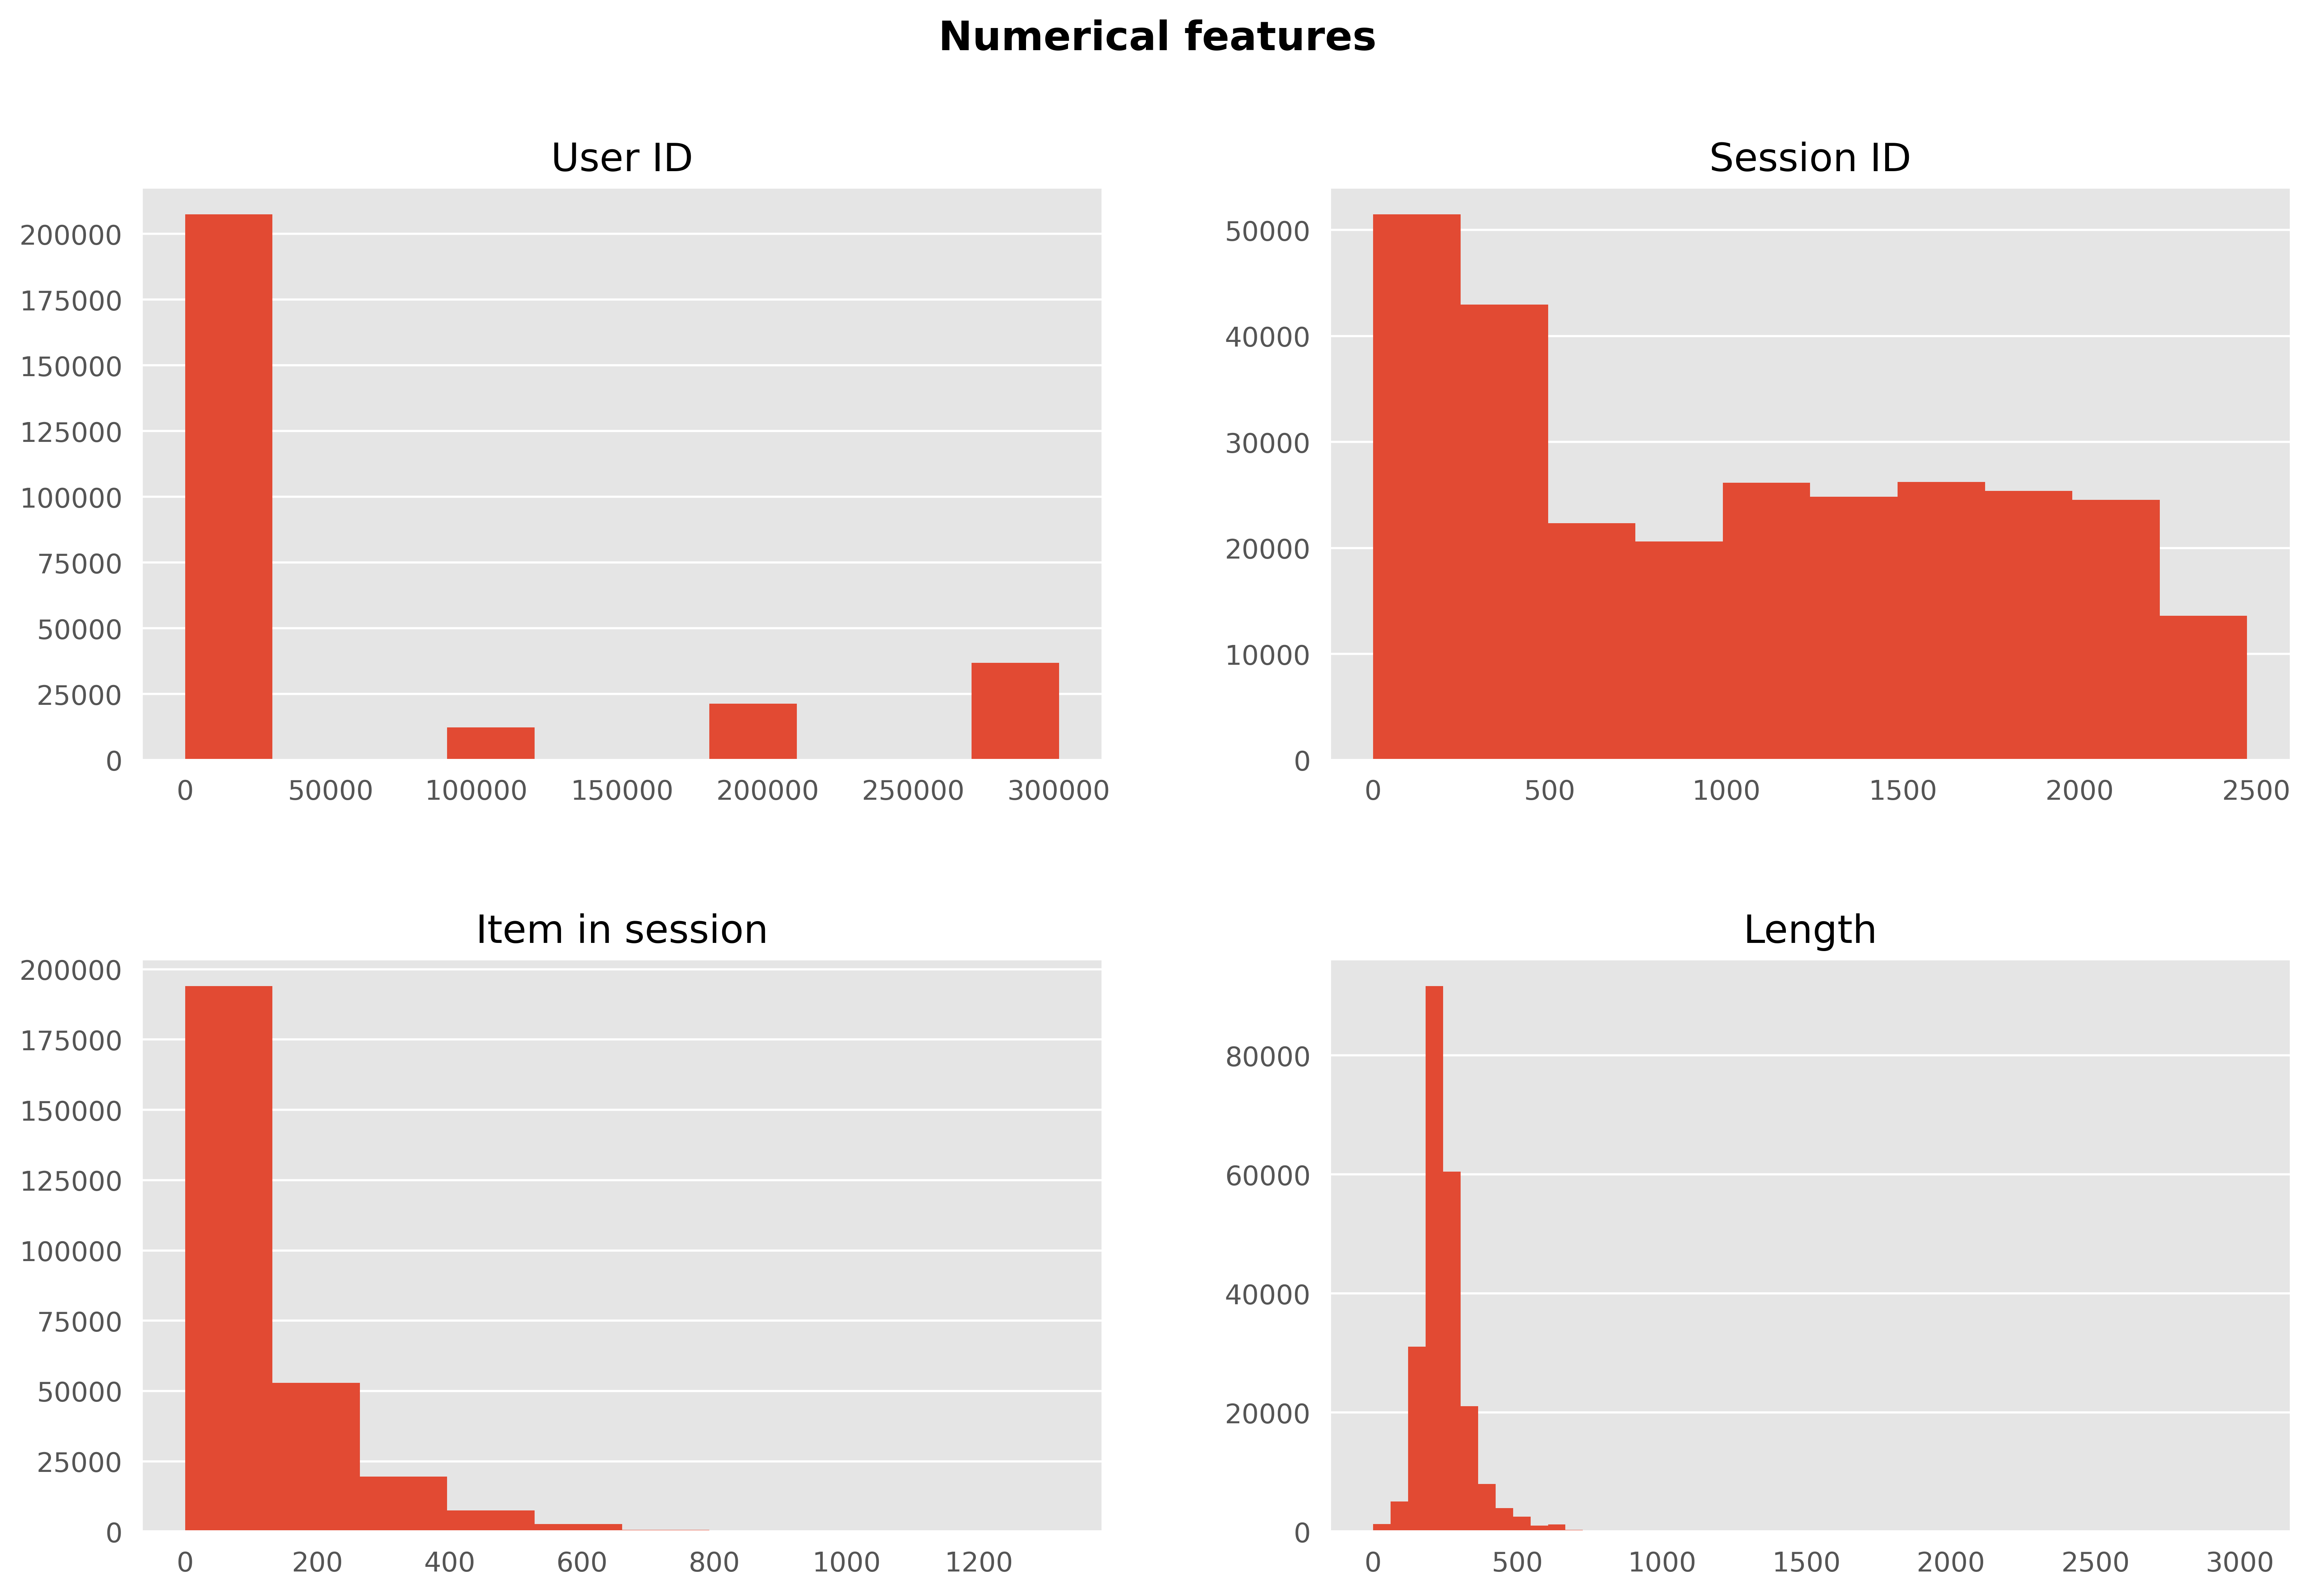

In [21]:
fig = plt.figure(figsize=(12, 8), dpi=500)
grid = gs.GridSpec(nrows=2, ncols=2)

fig.text(0.5, 1, 'Numerical features', ha='center', size=15, weight='bold')

Hist(n1, title='User ID').subplot(grid, 0, 0)
Hist(n2, title='Session ID').subplot(grid, 0, 1)
Hist(n3, title='Item in session').subplot(grid, 1, 0)
Hist(n4, title='Length', bins=50).subplot(grid, 1, 1)
    
plt.tight_layout(h_pad=4, w_pad=4, rect=(0, 0, 1, 0.96))
plt.show();

#### 2.1.2. Categorical features

In [22]:
def group_by_count_column(df, column, n_labels=20, n_label_chars=20):
    """Perform a group by and count the values from a desired column.
    
    Parameters:
        df (Spark dataframe): The dataframe that contains the column.
        column (String): The name of the column, from the df, to perform the group by and count its values.
    
    Returns:
        x:
        y:
    """
    
    group_by_count = df.select(column).groupby(column).count().toPandas().sort_values(by='count')
    
    x = group_by_count[column][-n_labels:]
    x = x.apply(lambda s: 'None' if s is None else s)
    x = x.apply(lambda s: s[:n_label_chars] + '...' if len(s) >= n_label_chars else s)
    
    y = group_by_count['count'][-n_labels:]
    
    return x, y

In [23]:
x_series, y_series = [], []
categorical_columns.remove('userAgent')  # User agent will be parsed and plotted latter

for column in categorical_columns:
    x, y = group_by_count_column(users_log_valid, column)
    x_series.append(x)
    y_series.append(y)

In [24]:
c1x, c2x, c3x, c4x, c5x, c6x, c7x, c8x, c9x, c10x = x_series
c1y, c2y, c3y, c4y, c5y, c6y, c7y, c8y, c9y, c10y = y_series

In [25]:
fig = plt.figure(figsize=(12, 24), dpi=500)
grid = gs.GridSpec(nrows=5, ncols=2)

fig.text(0.5, 1, 'Categorical features (top 20 classes)', ha='center', size=15, weight='bold')

Barh(c1x, c1y, title='Artist').subplot(grid, 0, 0)
Barh(c2x, c2y, title='Auth').subplot(grid, 0, 1)
Barh(c3x, c3y, title='First name').subplot(grid, 1, 0)
Barh(c4x, c4y, title='Gender', nbins=6).subplot(grid, 1, 1)
Barh(c5x, c5y, title='Last name').subplot(grid, 2, 0)
Barh(c6x, c6y, title='Level').subplot(grid, 2, 1)
Barh(c7x, c7y, title='Location').subplot(grid, 3, 0)
Barh(c8x, c8y, title='Method').subplot(grid, 3, 1)
Barh(c9x, c9y, title='Page').subplot(grid, 4, 0)
Barh(c10x, c10y, title='Song').subplot(grid, 4, 1)
    
plt.tight_layout(h_pad=3, w_pad=2, rect=(0, 0, 1, 0.985))
plt.show();

### 2.2. Defining churn
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [26]:
# Flag the churn

flag_cancellation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
users_log_valid = users_log_valid.withColumn('churn', flag_cancellation_event('page'))

In [27]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
users_log_valid = users_log_valid.withColumn('churned', Fsum('churn').over(windowval))

In [28]:
users_log_valid \
    .select('userId', 'churned') \
    .dropDuplicates(['userId']) \
    .groupBy('churned') \
    .count() \
    .show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



### 2.3. Extracting new features

In [29]:
# Add the cohort

users_log_valid = users_log_valid.withColumn('cohort', substring('registration', 1, 7))

In [30]:
# Split the location between state and city

users_log_valid = users_log_valid.withColumn('city', split('location', ',')[0])
users_log_valid = users_log_valid.withColumn('state', split('location', ',')[1])
users_log_valid = users_log_valid.drop('location')

In [31]:
users_log_valid \
    .select('userId', 'cohort') \
    .dropDuplicates(['userId']) \
    .groupBy('cohort') \
    .count() \
    .orderBy('cohort') \
    .show()

+-------+-----+
| cohort|count|
+-------+-----+
|2018-03|    1|
|2018-05|    2|
|2018-06|   10|
|2018-07|   28|
|2018-08|   50|
|2018-09|  129|
|2018-10|    1|
|2018-11|    4|
+-------+-----+



### 2.4. Parsing user agent

In [32]:
users_log_valid.select('userAgent').dropDuplicates(['userAgent']).limit(5).toPandas().head()

userAgent
0  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"
1                    "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"
2                                                  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0
3  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"
4  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"

In [33]:
# Parse the user agent into: browser, os, device, isPhone, isTablet and isComputer

get_browser     = udf(lambda x: parse(x).browser.family, StringType())
get_os          = udf(lambda x: parse(x).os.family, StringType())
get_device      = udf(lambda x: parse(x).device.family, StringType())
get_is_phone    = udf(lambda x: 1 if parse(x).is_mobile else 0, IntegerType())
get_is_tablet   = udf(lambda x: 1 if parse(x).is_tablet else 0, IntegerType())
get_is_computer = udf(lambda x: 1 if parse(x).is_pc else 0, IntegerType())

In [34]:
users_log_valid = users_log_valid.withColumn('browser', get_browser('userAgent'))
users_log_valid = users_log_valid.withColumn('os', get_os('userAgent'))
users_log_valid = users_log_valid.withColumn('device', get_device('userAgent'))
users_log_valid = users_log_valid.withColumn('isPhone', get_is_phone('userAgent'))
users_log_valid = users_log_valid.withColumn('isTablet', get_is_tablet('userAgent'))
users_log_valid = users_log_valid.withColumn('isComputer', get_is_computer('userAgent'))

In [35]:
users_log_valid \
    .select('userAgent', 'browser', 'os', 'device', 'isPhone', 'isTablet', 'isComputer') \
    .dropDuplicates(['userAgent']) \
    .limit(5) \
    .toPandas() \
    .head()

userAgent  \
0  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"   
1                    "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"   
2                                                  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0   
3  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"   
4  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"   

   browser        os device  isPhone  isTablet  isComputer  
0   Chrome  Mac OS X    Mac        0         0           1  
1   Chrome   Windows  Other        0         0           1  
2  Firefox    Ubuntu  Other        0         0           1  
3   Chrome  Mac OS X    Mac        0         0           1  
4   Chrome  Mac OS X    Mac        0         0           1

In [36]:
user_agent_per_user = users_log_valid \
    .select('userId', 'browser', 'os', 'device', 'isPhone', 'isTablet', 'isComputer') \
    .groupBy('userId', 'browser', 'os', 'device', 'isPhone', 'isTablet', 'isComputer') \
    .count()

In [37]:
print('User IDs and User Agent variations:', user_agent_per_user.count())
print('Since it is equal to the number of distinct users ({}), each User ID has just one User Agent.'.format(distinct_user_ids))

User IDs and User Agent variations: 225
Since it is equal to the number of distinct users (225), each User ID has just one User Agent.


In [38]:
users_log_valid \
    .select('browser') \
    .groupBy('browser') \
    .count() \
    .orderBy(desc('count')) \
    .show()

+-------------+------+
|      browser| count|
+-------------+------+
|       Chrome|145591|
|      Firefox| 55646|
|       Safari| 38997|
|Mobile Safari| 22573|
|           IE| 15347|
+-------------+------+



In [39]:
users_log_valid \
    .select('device') \
    .groupBy('device') \
    .count() \
    .orderBy(desc('count')) \
    .show()

+------+------+
|device| count|
+------+------+
| Other|152832|
|   Mac|102749|
|  iPad| 11381|
|iPhone| 11192|
+------+------+



In [40]:
users_log_valid \
    .select('os') \
    .groupBy('os') \
    .count() \
    .orderBy(desc('count')) \
    .show()

+--------+------+
|      os| count|
+--------+------+
| Windows|143871|
|Mac OS X|102749|
|     iOS| 22573|
|   Linux|  7025|
|  Ubuntu|  1936|
+--------+------+



In [41]:
users_log_valid \
    .select('isPhone') \
    .groupBy('isPhone') \
    .count() \
    .orderBy(desc('count')) \
    .show()

+-------+------+
|isPhone| count|
+-------+------+
|      0|266962|
|      1| 11192|
+-------+------+



In [42]:
users_log_valid \
    .select('isTablet') \
    .groupBy('isTablet') \
    .count() \
    .orderBy(desc('count')) \
    .show()

+--------+------+
|isTablet| count|
+--------+------+
|       0|266773|
|       1| 11381|
+--------+------+



In [43]:
users_log_valid \
    .select('isComputer') \
    .groupBy('isComputer') \
    .count() \
    .orderBy(desc('count')) \
    .show()

+----------+------+
|isComputer| count|
+----------+------+
|         1|255581|
|         0| 22573|
+----------+------+



### 2.5. Understanting relationships

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [44]:
def get_labels(df, column):
    
    labels = df.select(column).dropDuplicates([column]).orderBy(column).toPandas()[column].tolist()
    
    return labels

In [45]:
def get_percentage(abs_values_1, abs_values_2):
    
    np_abs_values_1, np_abs_values_2 = np.array(abs_values_1), np.array(abs_values_2)
    
    totals = np.sum([np_abs_values_1, np_abs_values_2], axis=0)
    
    perc_values_1 = list(np_abs_values_1 / totals * 100)
    perc_values_2 = list(np_abs_values_2 / totals * 100)

    return perc_values_1, perc_values_2

In [46]:
def get_plot_inputs(df, column, order_by='label', perc=False):

    counts = df \
        .select('userId', column, 'churned') \
        .dropDuplicates(['userId']) \
        .groupBy('churned', column) \
        .count() \
        .toPandas()
    
    labels = get_labels(df, column)
    churned, stayed = [], []

    for label in labels:
        filtered_label = counts[counts[column] == label]
        
        churned_count = filtered_label[filtered_label['churned'] == 1]
        if churned_count.shape[0] == 0:
            churned.append(0)
        else:
            count = counts[(counts[column] == label) & (counts['churned'] == 1)].values[0,2]
            churned.append(count)
        
        stayed_count = filtered_label[filtered_label['churned'] == 0]
        if stayed_count.shape[0] == 0:
            stayed.append(0)
        else:
            count = counts[(counts[column] == label) & (counts['churned'] == 0)].values[0,2]
            stayed.append(count)
    
    # the first list in the zip function defines the order of the sorting
    
    if order_by == 'label':
        zipped_lists = zip(labels, churned, stayed)
        sorted_zipped_lists = sorted(zipped_lists)
        unzipped_list = list(zip(*sorted_zipped_lists))
        churned, stayed, labels = list(unzipped_list[1]), list(unzipped_list[2]), list(unzipped_list[0])
        
    elif order_by == 'abs':
        zipped_lists = zip(churned, stayed, labels)
        sorted_zipped_lists = sorted(zipped_lists)
        unzipped_list = list(zip(*sorted_zipped_lists))
        churned, stayed, labels = list(unzipped_list[0]), list(unzipped_list[1]), list(unzipped_list[2])
        
    elif order_by == 'perc':
        churned_p, stayed_p = get_percentage(churned, stayed)
        zipped_lists = zip(churned_p, stayed_p, churned, stayed, labels)
        sorted_zipped_lists = sorted(zipped_lists)
        unzipped_list = list(zip(*sorted_zipped_lists))
        churned, stayed, labels = list(unzipped_list[2]), list(unzipped_list[3]), list(unzipped_list[4])
    
    if perc == True:
        churned, stayed = get_percentage(churned, stayed)
    
    return churned, stayed, labels

In [47]:
legend = ['Churned', 'Stayed']

In [48]:
c_level,  s_level,  l_level  = get_plot_inputs(users_log_valid, 'level')
c_gender, s_gender, l_gender = get_plot_inputs(users_log_valid, 'gender')

c_level_p,  s_level_p  = get_percentage(c_level,  s_level)
c_gender_p, s_gender_p = get_percentage(c_gender, s_gender)

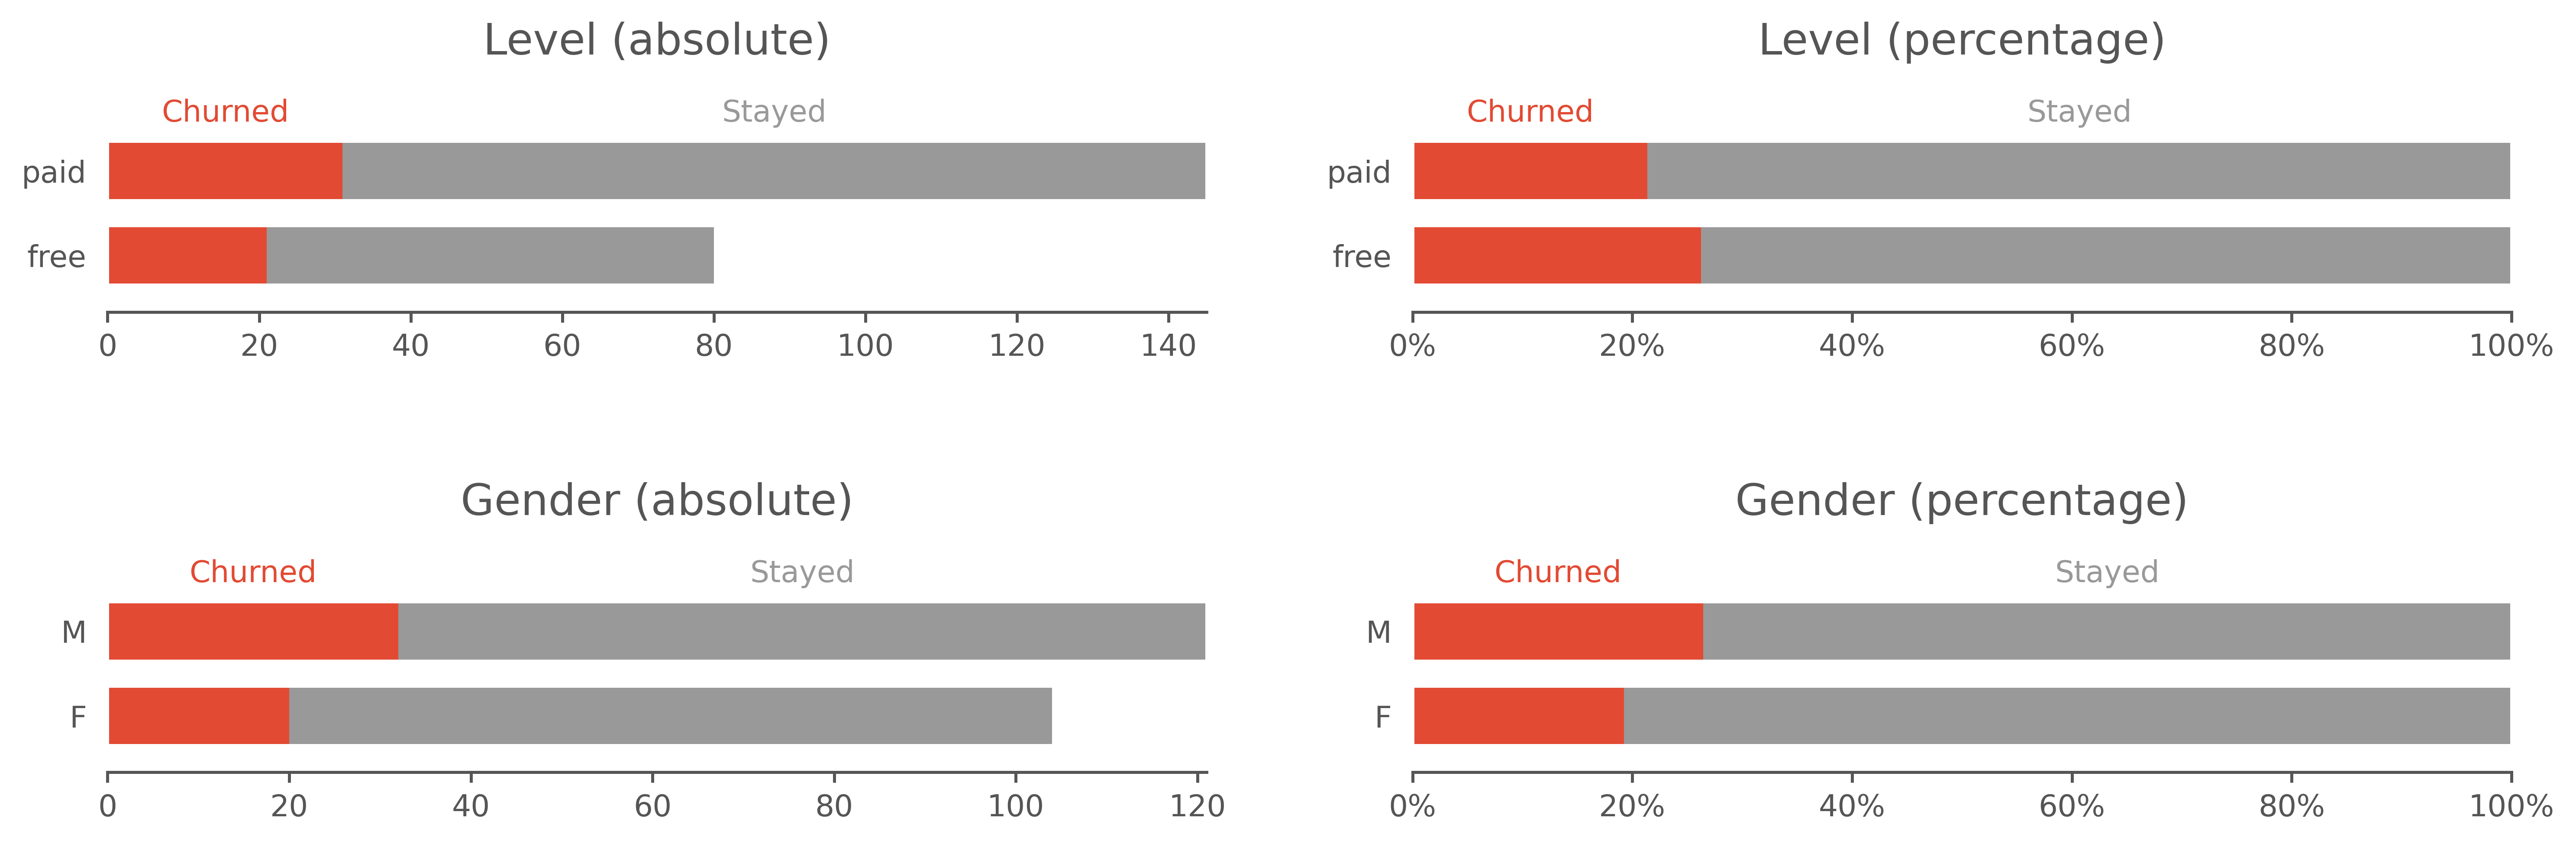

In [49]:
fig = plt.figure(figsize=(12, 4), dpi=500)
grid = gs.GridSpec(nrows=2, ncols=2)

BarhStacked2(c_level,    s_level,    l_level,  'Level (absolute)',    legend           ).subplot(grid, 0, 0)
BarhStacked2(c_level_p,  s_level_p,  l_level,  'Level (percentage)',  legend, perc=True).subplot(grid, 0, 1)
BarhStacked2(c_gender,   s_gender,   l_gender, 'Gender (absolute)',   legend           ).subplot(grid, 1, 0)
BarhStacked2(c_gender_p, s_gender_p, l_gender, 'Gender (percentage)', legend, perc=True).subplot(grid, 1, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [50]:
c_cohort, s_cohort, l_cohort = get_plot_inputs(users_log_valid, 'cohort')
c_cohort_p, s_cohort_p = get_percentage(c_cohort, s_cohort)

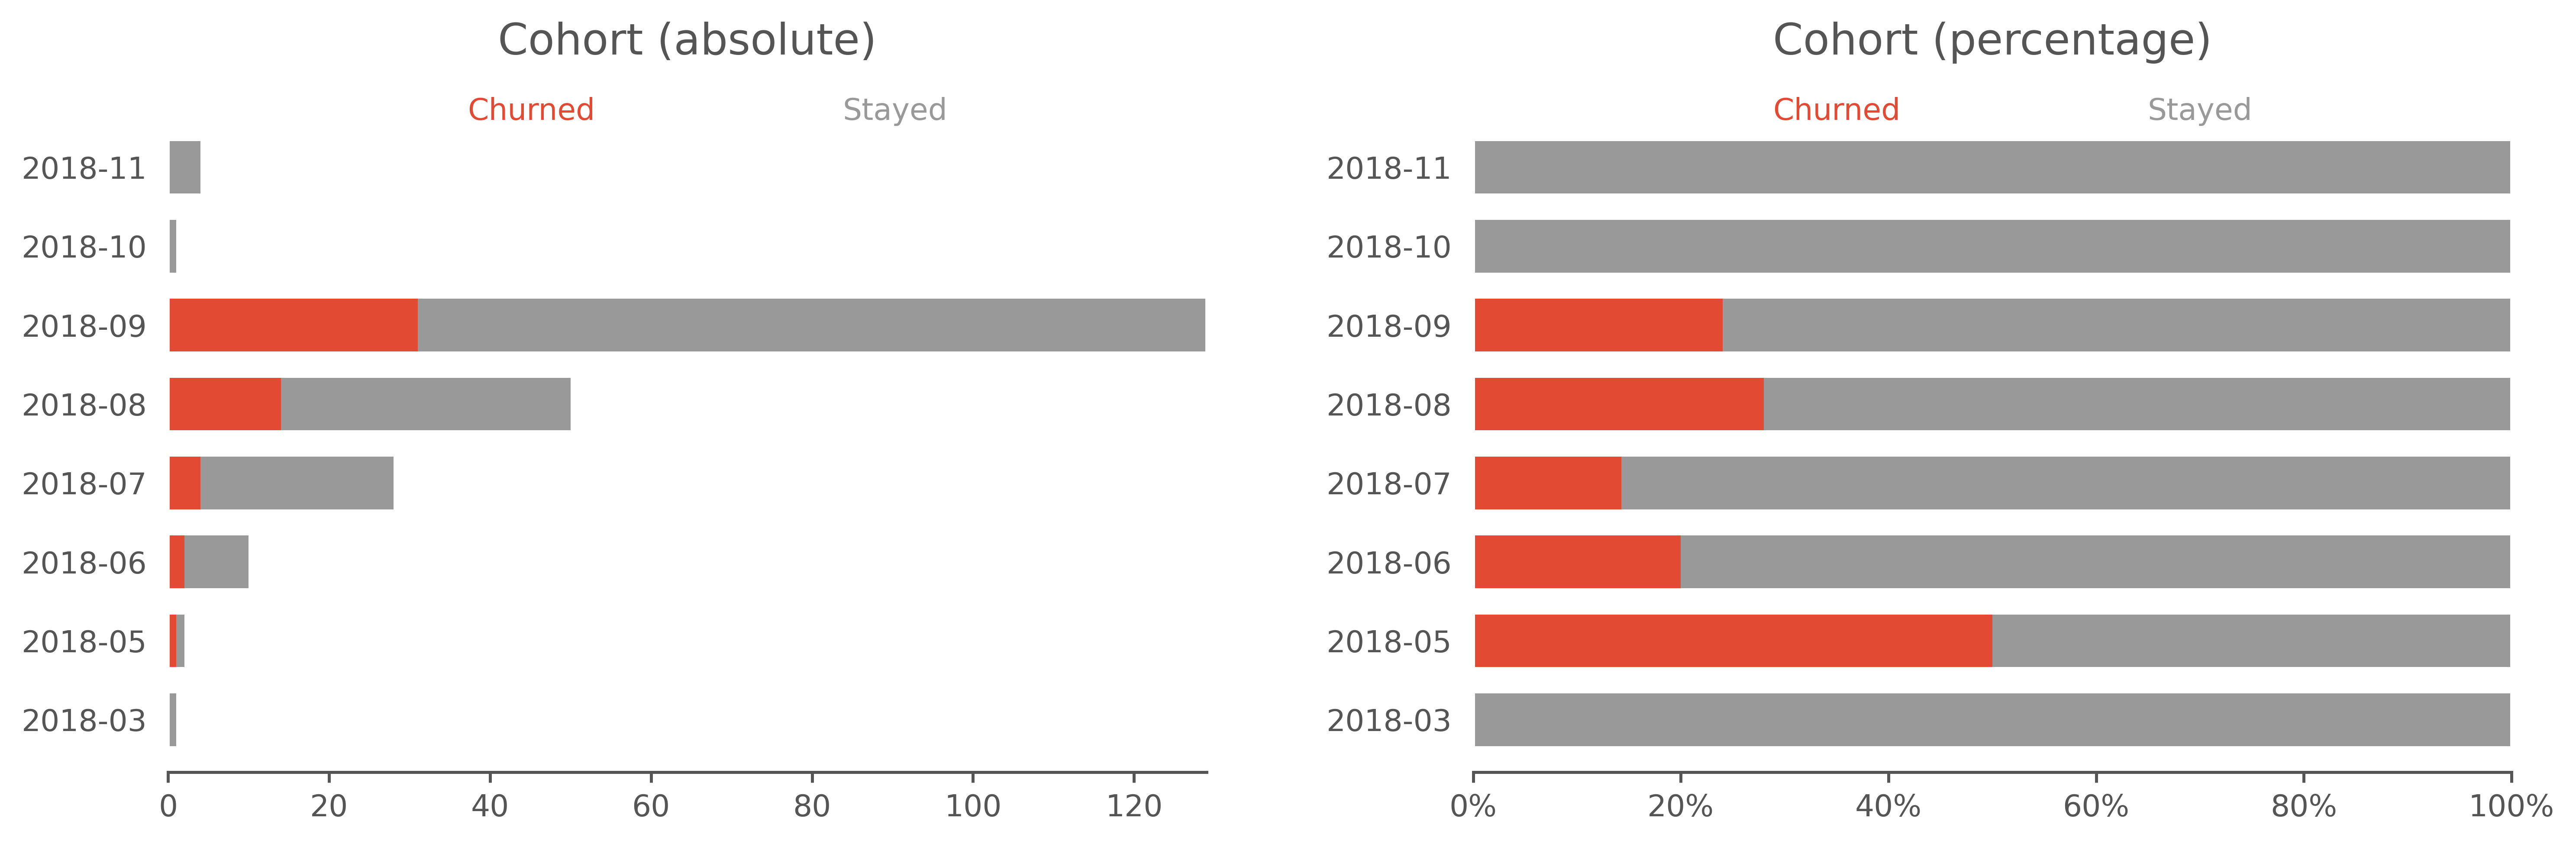

In [51]:
fig = plt.figure(figsize=(12, 4), dpi=500)
grid = gs.GridSpec(nrows=1, ncols=2)

BarhStacked2(c_cohort,   s_cohort,   l_cohort, 'Cohort (absolute)',   legend           ).subplot(grid, 0, 0)
BarhStacked2(c_cohort_p, s_cohort_p, l_cohort, 'Cohort (percentage)', legend, perc=True).subplot(grid, 0, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [52]:
c_browser, s_browser, l_browser = get_plot_inputs(users_log_valid, 'browser', order_by='abs')
c_device,  s_device,  l_device  = get_plot_inputs(users_log_valid, 'device',  order_by='abs')
c_os,      s_os,      l_os      = get_plot_inputs(users_log_valid, 'os',      order_by='abs')

c_browser_p, s_browser_p = get_percentage(c_browser, s_browser)
c_device_p,  s_device_p  = get_percentage(c_device,  s_device)
c_os_p,      s_os_p      = get_percentage(c_os,      s_os)

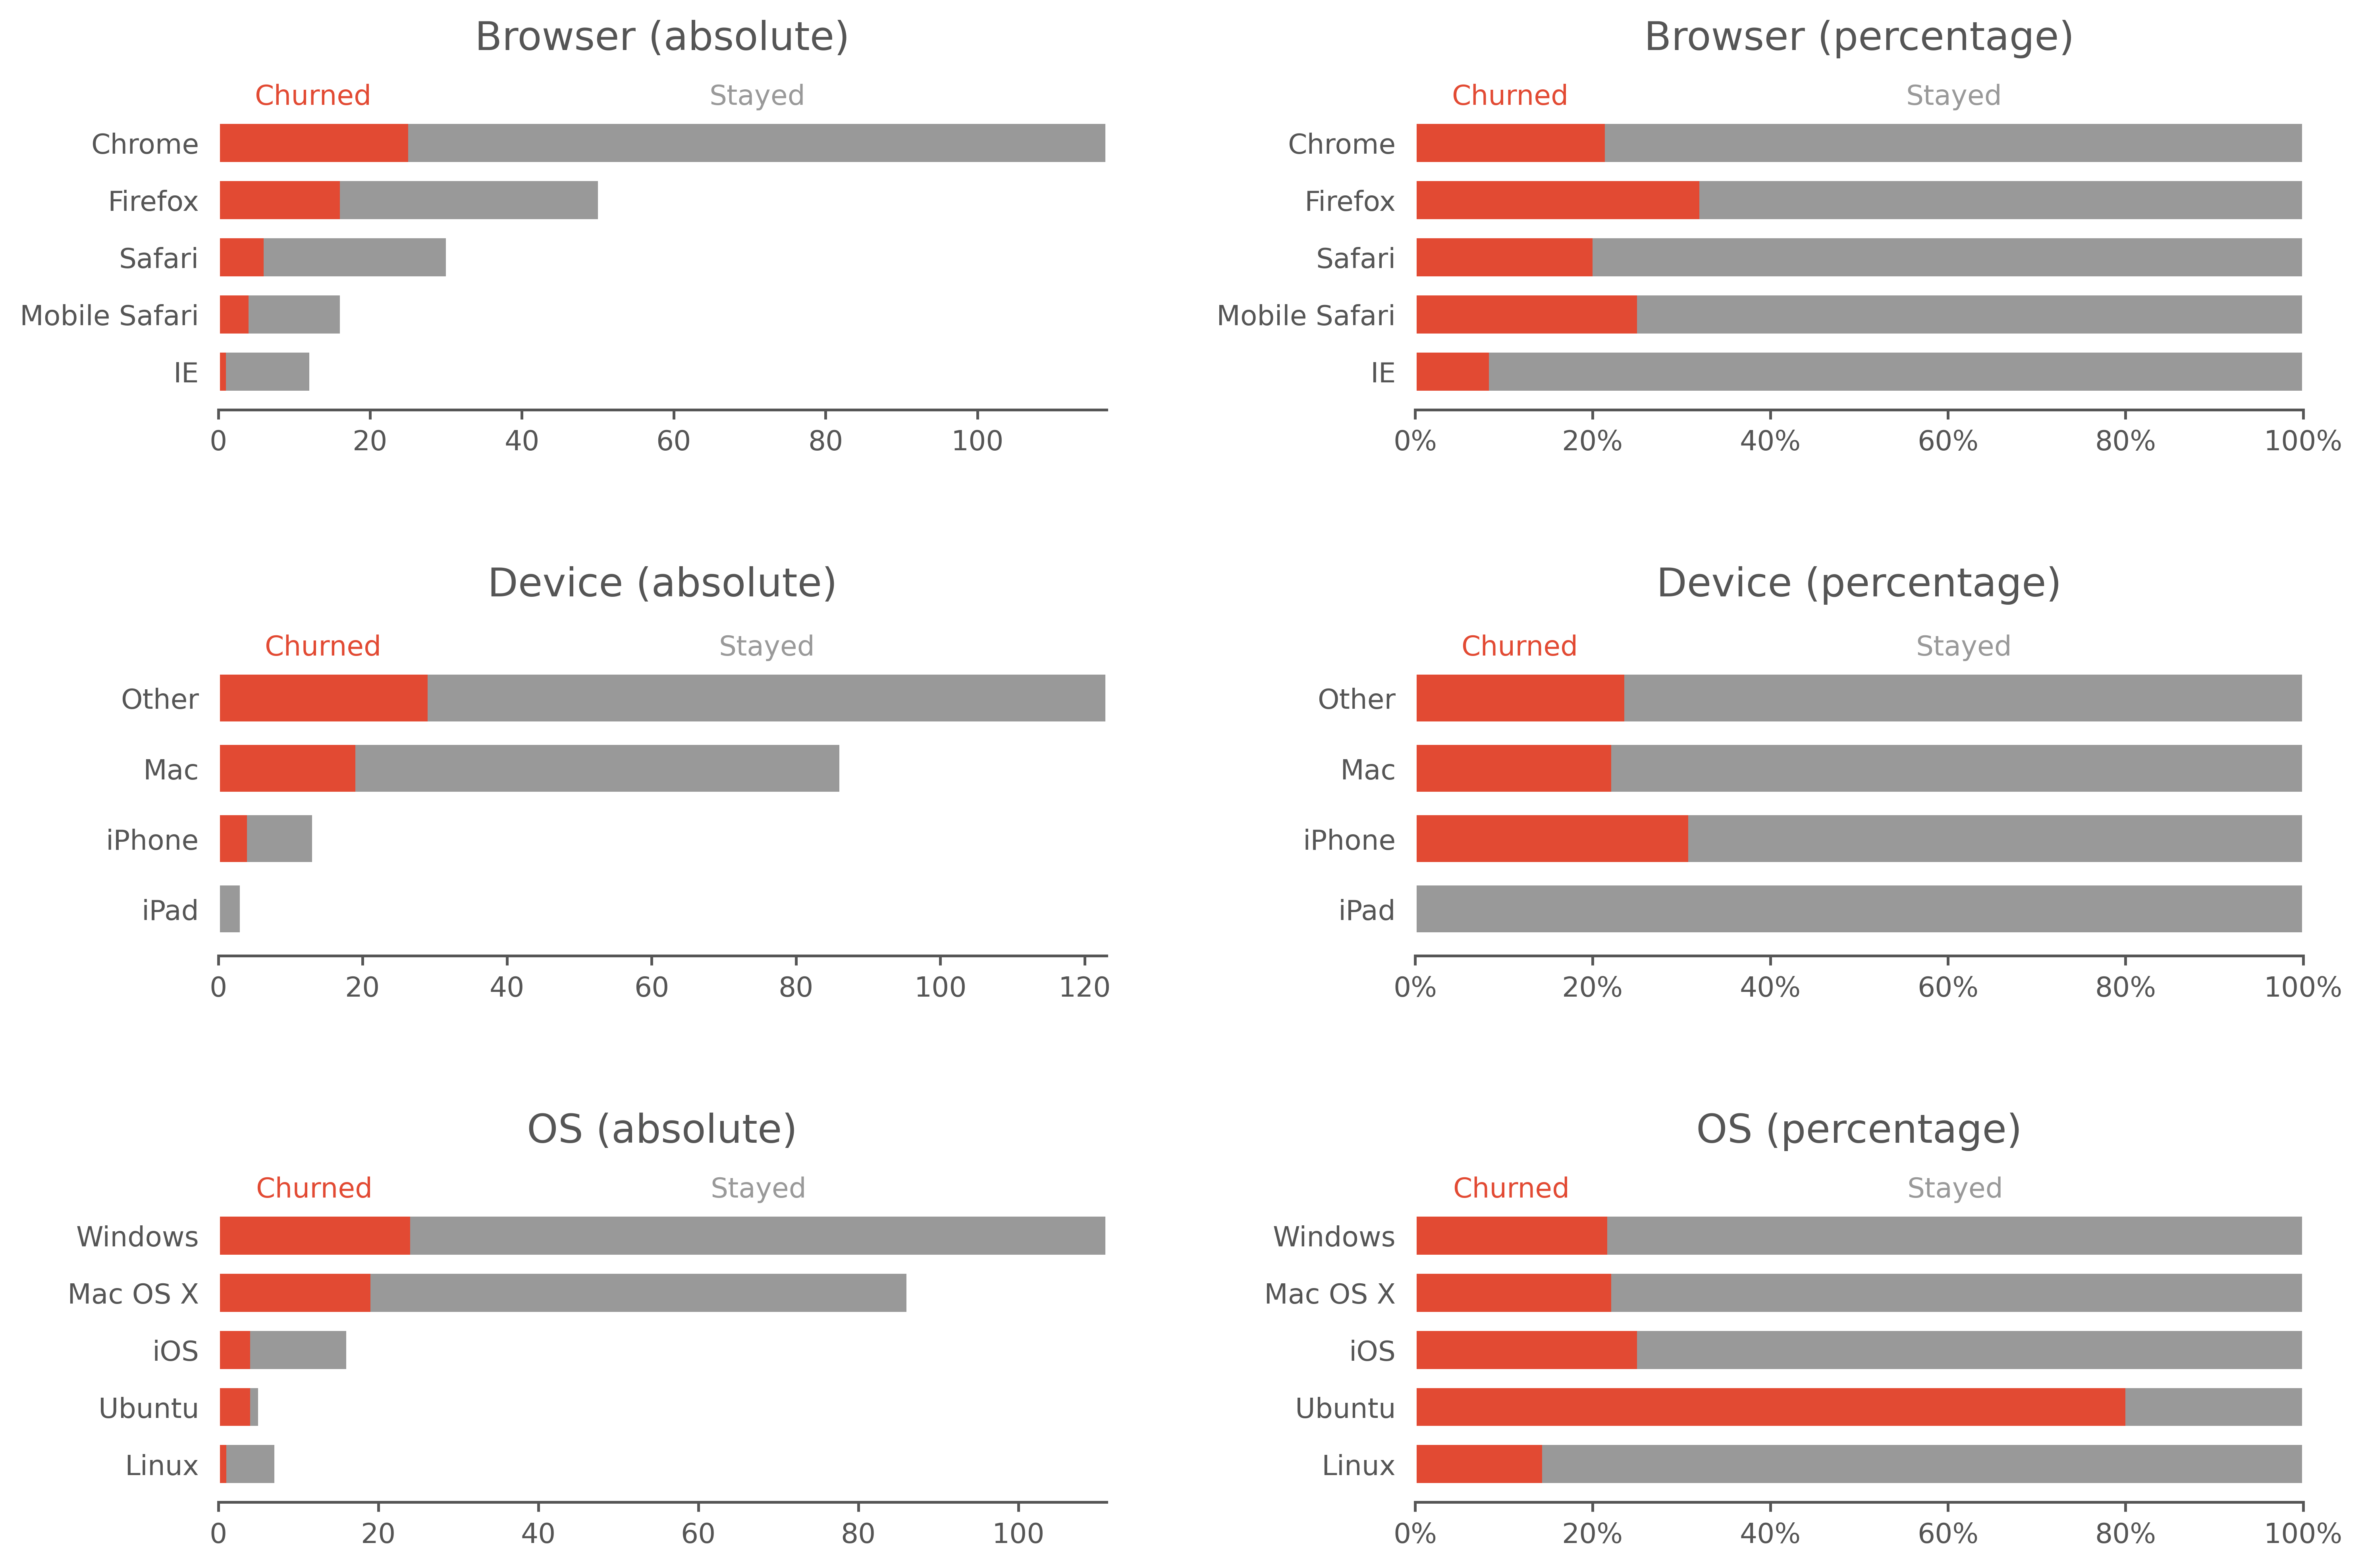

In [53]:
fig = plt.figure(figsize=(12, 8), dpi=500)
grid = gs.GridSpec(nrows=3, ncols=2)

BarhStacked2(c_browser,   s_browser,   l_browser, 'Browser (absolute)',   legend           ).subplot(grid, 0, 0)
BarhStacked2(c_browser_p, s_browser_p, l_browser, 'Browser (percentage)', legend, perc=True).subplot(grid, 0, 1)
BarhStacked2(c_device,    s_device,    l_device,  'Device (absolute)',    legend           ).subplot(grid, 1, 0)
BarhStacked2(c_device_p,  s_device_p,  l_device,  'Device (percentage)',  legend, perc=True).subplot(grid, 1, 1)
BarhStacked2(c_os,        s_os,        l_os,      'OS (absolute)',        legend           ).subplot(grid, 2, 0)
BarhStacked2(c_os_p,      s_os_p,      l_os,      'OS (percentage)',      legend, perc=True).subplot(grid, 2, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

In [54]:
c_phone,    s_phone,    l_phone    = get_plot_inputs(users_log_valid, 'isPhone',    order_by='abs')
c_tablet,   s_tablet,   l_tablet   = get_plot_inputs(users_log_valid, 'isTablet',   order_by='abs')
c_computer, s_computer, l_computer = get_plot_inputs(users_log_valid, 'isComputer', order_by='abs')

c_phone_p,    s_phone_p    = get_percentage(c_phone,    s_phone)
c_tablet_p,   s_tablet_p   = get_percentage(c_tablet,   s_tablet)
c_computer_p, s_computer_p = get_percentage(c_computer, s_computer)

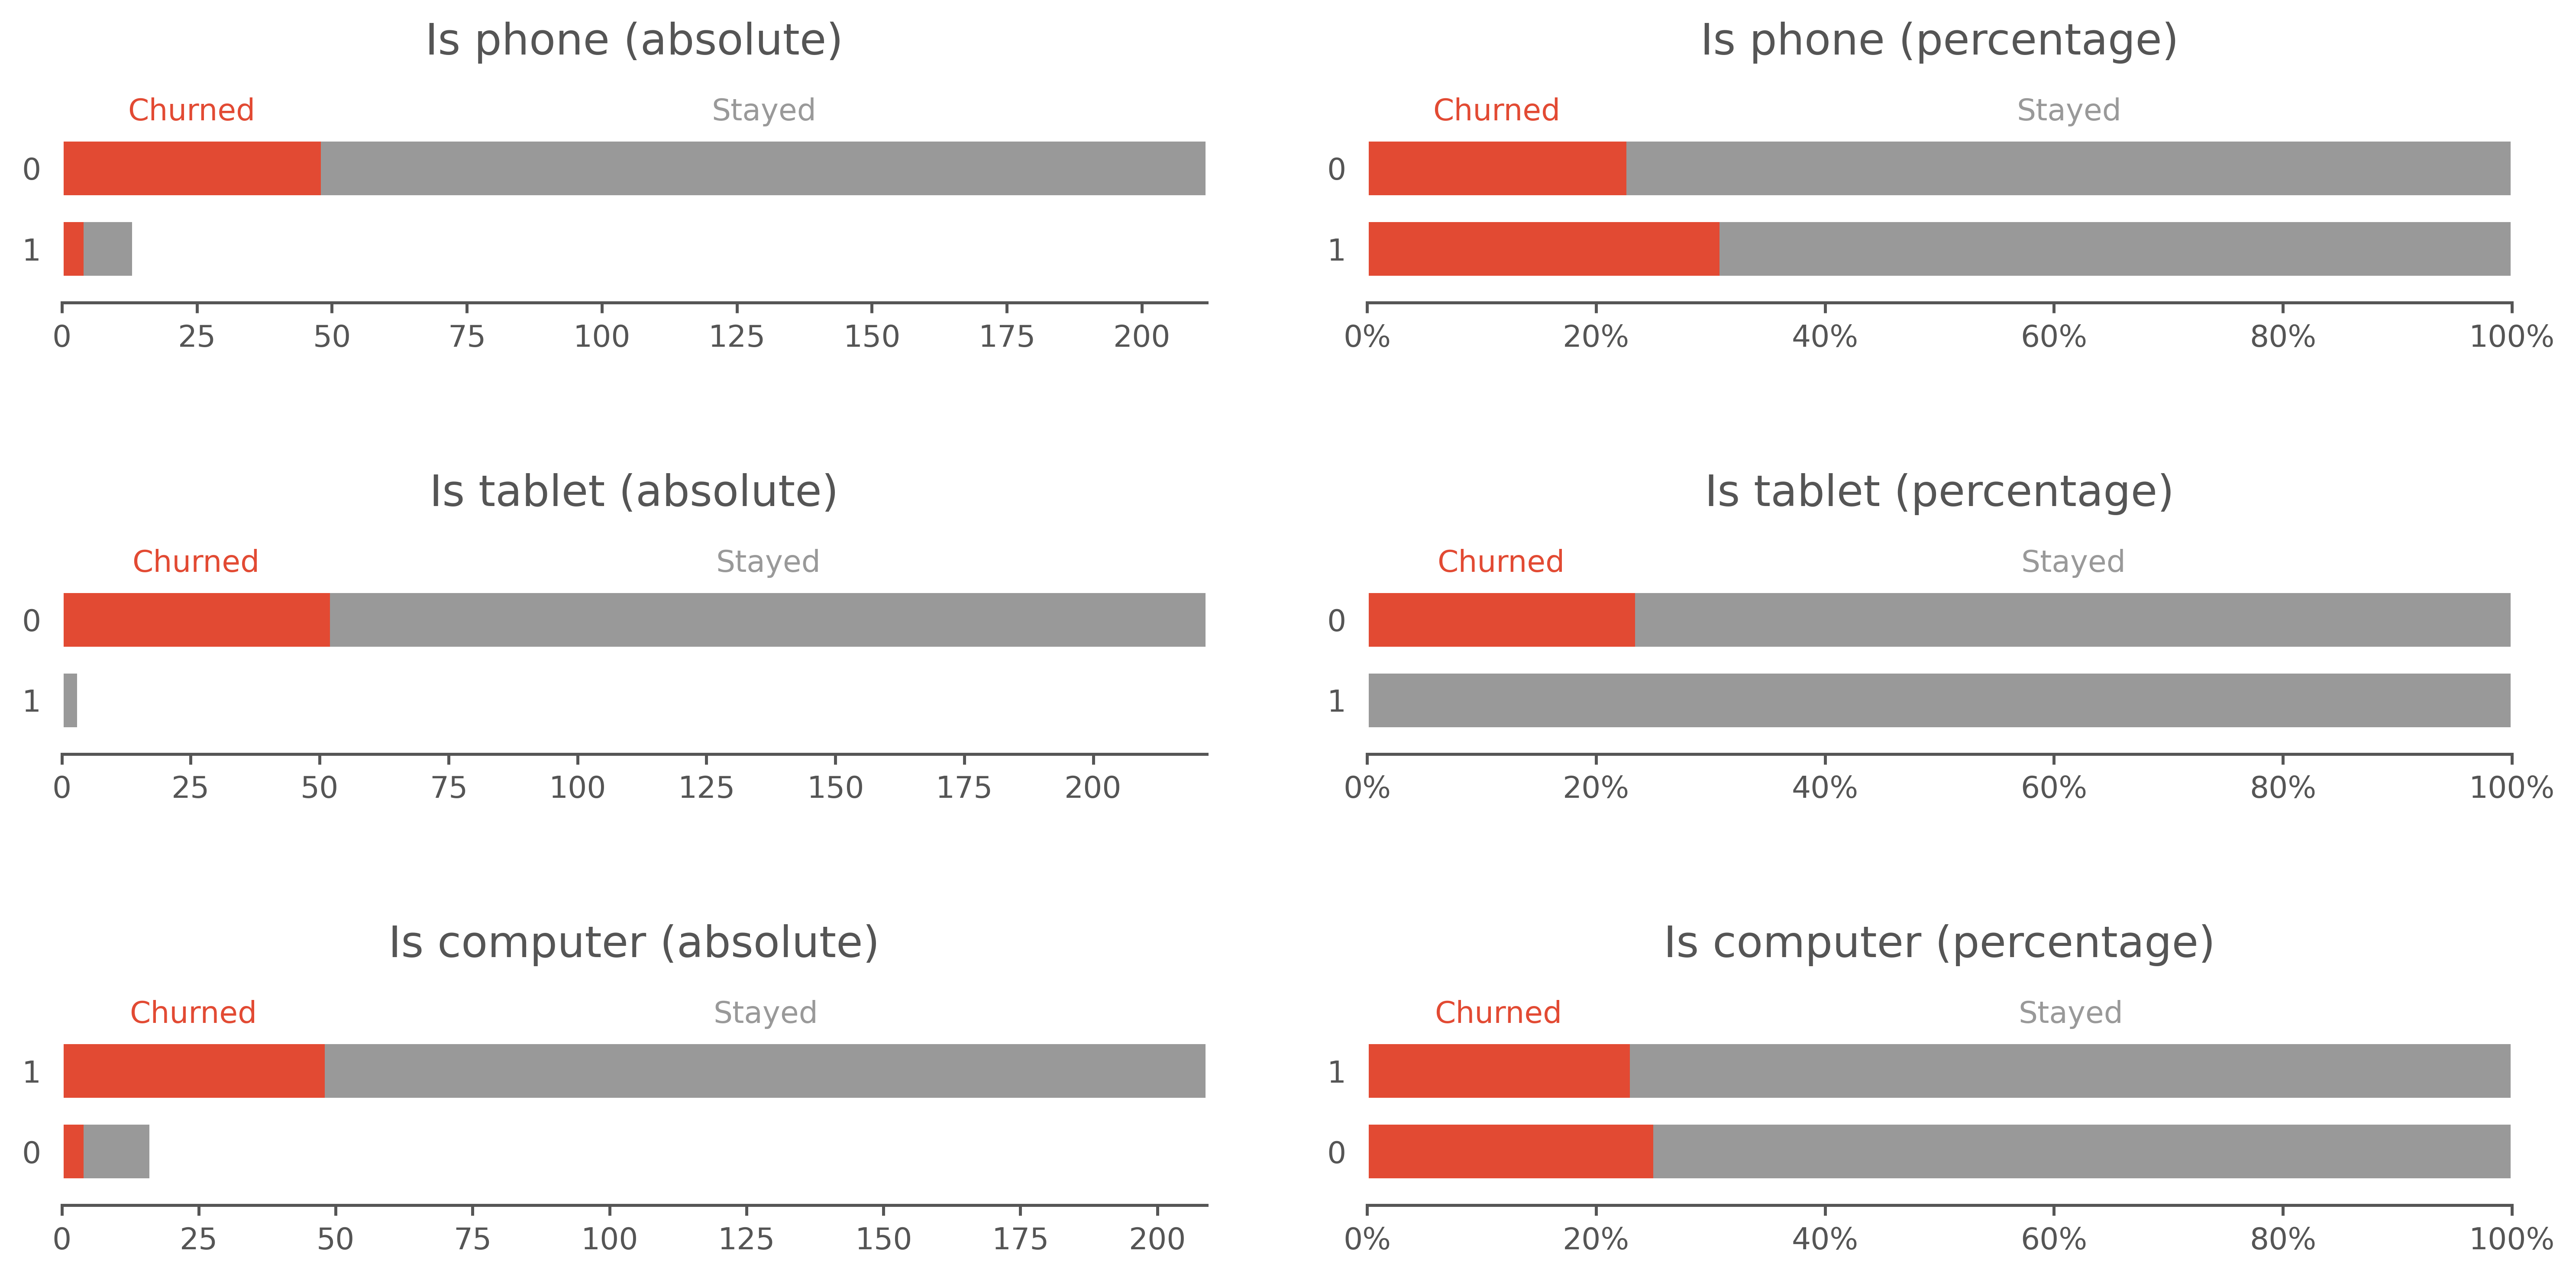

In [55]:
fig = plt.figure(figsize=(12, 6), dpi=500)
grid = gs.GridSpec(nrows=3, ncols=2)

BarhStacked2(c_phone,      s_phone,      l_phone,    'Is phone (absolute)',      legend           ).subplot(grid, 0, 0)
BarhStacked2(c_phone_p,    s_phone_p,    l_phone,    'Is phone (percentage)',    legend, perc=True).subplot(grid, 0, 1)
BarhStacked2(c_tablet,     s_tablet,     l_tablet,   'Is tablet (absolute)',     legend           ).subplot(grid, 1, 0)
BarhStacked2(c_tablet_p,   s_tablet_p,   l_tablet,   'Is tablet (percentage)',   legend, perc=True).subplot(grid, 1, 1)
BarhStacked2(c_computer,   s_computer,   l_computer, 'Is computer (absolute)',   legend           ).subplot(grid, 2, 0)
BarhStacked2(c_computer_p, s_computer_p, l_computer, 'Is computer (percentage)', legend, perc=True).subplot(grid, 2, 1)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show();

## 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.

- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [58]:
users_log_valid.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'churn',
 'churned',
 'cohort',
 'city',
 'state',
 'browser',
 'os',
 'device',
 'isPhone',
 'isTablet',
 'isComputer']

In [62]:
columns = ['userId',
           'churned',
           'gender',
           'cohort',
           'browser',
           'os',
           'device',
           'isPhone',
           'isTablet',
           'isComputer']

In [74]:
unique_users = users_log_valid.select(columns).dropDuplicates(['userId']).drop('userId')

## 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [76]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoderEstimator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator

In [84]:
indexer_gender  = StringIndexer(inputCol='gender',  outputCol='gender_index')
indexer_cohort  = StringIndexer(inputCol='cohort',  outputCol='cohort_index')
indexer_browser = StringIndexer(inputCol='browser', outputCol='browser_index')
indexer_device  = StringIndexer(inputCol='device',  outputCol='device_index')
indexer_os      = StringIndexer(inputCol='os',      outputCol='os_index')

In [102]:
ohe_inputs = ['gender_index', 'cohort_index', 'browser_index', 'device_index', 'os_index']
ohe_outputs = ['gender_ohe', 'cohort_ohe', 'browser_ohe', 'device_ohe', 'os_ohe']

In [103]:
one_hot_encoder = OneHotEncoderEstimator(inputCols=ohe_inputs, outputCols=ohe_outputs)

In [104]:
pipeline = Pipeline(stages=[
    indexer_gender,
    indexer_cohort,
    indexer_browser,
    indexer_device,
    indexer_os,
    one_hot_encoder
])

In [ ]:
pipeline_features = pipeline.fit(unique_users)
df_features = pipeline_features.transform(unique_users)

In [106]:
df_features.toPandas().head()

churned gender   cohort  browser        os device  isPhone  isTablet  \
0        0      M  2018-09  Firefox   Windows  Other        0         0   
1        1      M  2018-09   Safari  Mac OS X    Mac        0         0   
2        0      M  2018-09  Firefox     Linux  Other        0         0   
3        0      M  2018-09   Chrome     Linux  Other        0         0   
4        1      M  2018-09   Safari  Mac OS X    Mac        0         0   

   isComputer  gender_index  cohort_index  browser_index  device_index  \
0           1           0.0           0.0            1.0           0.0   
1           1           0.0           0.0            2.0           1.0   
2           1           0.0           0.0            1.0           0.0   
3           1           0.0           0.0            0.0           0.0   
4           1           0.0           0.0            2.0           1.0   

   os_index                           cohort_ohe gender_ohe  \
0       0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)      (1.0)   
1       1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)      (1.0)   
2       3.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)      (1.0)   
3       3.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)      (1.0)   
4       1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)      (1.0)   

            browser_ohe       device_ohe                os_ohe  
0  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0, 0.0)  (1.0, 0.0, 0.0, 0.0)  
1  (0.0, 0.0, 1.0, 0.0)  (0.0, 1.0, 0.0)  (0.0, 1.0, 0.0, 0.0)  
2  (0.0, 1.0, 0.0, 0.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)  
3  (1.0, 0.0, 0.0, 0.0)  (1.0, 0.0, 0.0)  (0.0, 0.0, 0.0, 1.0)  
4  (0.0, 0.0, 1.0, 0.0)  (0.0, 1.0, 0.0)  (0.0, 1.0, 0.0, 0.0)

## 5. Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Drafts

In [183]:
pages = users_log_valid \
    .select('page') \
    .dropDuplicates(['page']) \
    .toPandas()

In [184]:
pages

page
0                      Cancel
1            Submit Downgrade
2                 Thumbs Down
3                        Home
4                   Downgrade
5                 Roll Advert
6                      Logout
7               Save Settings
8   Cancellation Confirmation
9                       About
10                   Settings
11            Add to Playlist
12                 Add Friend
13                   NextSong
14                  Thumbs Up
15                       Help
16                    Upgrade
17                      Error
18             Submit Upgrade

In [188]:
pages_per_user = users_log_valid \
    .select('userId', 'page') \
    .groupBy('userId', 'page') \
    .count() \
    .orderBy('userId', 'page') \
    .toPandas()

In [186]:
test.shape

(3109, 3)

In [189]:
test.head(10)

userId             page  count
0       2            About      3
1       2       Add Friend     20
2       2  Add to Playlist     13
3       2        Downgrade     13
4       2             Help      4
5       2             Home     35
6       2           Logout     11
7       2         NextSong    755
8       2    Save Settings      4
9       2         Settings      6

In [ ]:
days_old_per_user = users_log_valid \
    .select('userId', 'registration')

In [316]:
# Add downgrade

flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
users_log_eda = users_log_eda.withColumn('downgraded', flag_downgrade_event('page'))

In [317]:
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
users_log_eda = users_log_eda.withColumn('phase', Fsum('downgraded').over(windowval))

In [321]:
users_log_eda \
    .select('registration', 'ts', 'userId', 'churn', 'downgraded', 'phase', 'level', 'page', 'auth', 'method', 'status') \
    .where('''userId == 20
              and ts > "2018-10-03 01:34:00"
              and ts < "2018-10-08 08:25:00"
              --and page == "Submit Downgrade"''') \
    .orderBy('ts') \
    .limit(10) \
    .toPandas() \
    .head(10)

# 29, 100012, 54, 100017, 32

#     .where('userId == 29') \
#     .where('downgraded == 1') \

#     .where('''userId == 20
#               and ts > "2018-10-03 01:34:00"
#               and ts < "2018-10-08 08:25:00"''') \

#     .where('''userId == 38
#               and ts > "2018-10-02 18:30:00"
#               and ts < "2018-10-04 23:59:59"''') \

#     .where('''userId == 29
#               and ts > "2018-11-14 05:20:00"
#               and ts < "2018-11-15 23:59:59"''') \

registration                   ts  userId  churn  downgraded  phase  \
0  2018-09-13 10:13:30  2018-10-03 01:34:51      20      0           0      2   
1  2018-09-13 10:13:30  2018-10-03 01:34:52      20      0           0      2   
2  2018-09-13 10:13:30  2018-10-08 08:14:00      20      0           0      2   
3  2018-09-13 10:13:30  2018-10-08 08:15:55      20      0           0      2   
4  2018-09-13 10:13:30  2018-10-08 08:15:56      20      0           1      2   
5  2018-09-13 10:13:30  2018-10-08 08:15:58      20      0           0      1   
6  2018-09-13 10:13:30  2018-10-08 08:17:16      20      0           0      1   
7  2018-09-13 10:13:30  2018-10-08 08:21:09      20      0           0      1   

  level              page       auth method  status  
0  paid          NextSong  Logged In    PUT     200  
1  paid         Thumbs Up  Logged In    PUT     307  
2  paid          NextSong  Logged In    PUT     200  
3  paid         Downgrade  Logged In    GET     200  
4  paid  Submit Downgrade  Logged In    PUT     307  
5  free              Home  Logged In    GET     200  
6  free          NextSong  Logged In    PUT     200  
7  free          NextSong  Logged In    PUT     200